 The aim of this development is to solve the issue of duplicate ads because it has no gain for both buyers and sellers. 
 In order to to do that, the chosen method is compare images from ads and conclude about duplication.
 
 In the development, it is assumed that images from same sellers are compared.
 
 No requirements have been made about processing time.

# -------------------------------------------------------------------------------------------

Could be interesting to first get labels of object of interest in both images, why not with yolo algorithm wich contains basics labels. 
There are two goals :
- fastly know if images does deal with same category of objects
- obtaining coordinates of the object of interest in the images
If images deal with different OOI, then they are different.
If images deal with same OOI, the algorithm gives us coordinates for the bounding boxes of those objects.

The idea is to remove background or other elements containing in the images that will disrupt the comparison.

# -------------------------------------------------------------------------------------------

For the future of the development, we assume that images are dealing with same objects of interest.


1. basic metrics : calcul of error based on euclidean distance between matrices and structural similarity
2. idea around stereo vision
3. score between key points of both images : Better than picking 100 random points is picking 100 important points. Certain parts of an image have more information than others (particularly at edges and corners), and these are the ones you'll want to use for smart image matching.


An idea to explore could be around content recommendation because it provides similar content than the actual

In [1]:
import sys
import json
import codecs
import glob
import time
import io
from PIL import Image, ImageEnhance, ImageOps
import cv2
import os
from skimage.measure import compare_ssim as ssim
import matplotlib.pyplot as plt
import numpy as np
import imageio
import imutils
import math

In [2]:
%matplotlib inline

In [3]:
#read image path
files = glob.glob("./data/test5/*")
files[0]

'./data/test5/50_787542253.jpg'

In [48]:
### IMAGE PREPROCESSING ###

In [49]:
#image rotation
files_tmp1 = list()
extension = files[0][-4:]
for path_img in files:
    image = Image.open(path_img)
    if hasattr(image, '_getexif'):
        orientation = 0x0112
        exif = image._getexif()
        if exif is not None:
            orientation = exif[orientation]
            rotations = {
                3: Image.ROTATE_180,
                6: Image.ROTATE_270,
                8: Image.ROTATE_90
            }
            if orientation in rotations:
                image = image.transpose(rotations[orientation])
    path_img_rotate = path_img.replace(extension,"_rotate"+extension)
    image.save(path_img_rotate)
    files_tmp1.append(path_img_rotate)
files_tmp1

['./data/test5/50_787542253_rotate.jpg',
 './data/test5/93_2015287802_rotate.jpg']

In [24]:
#https://towardsdatascience.com/computer-vision-for-beginners-part-4-64a8d9856208

In [25]:
# Remove white band around images
# the aim of this part is to get an image full of information
# could be better to perform an object detection to find the object of interest and to remove the other elements
files_tmp2 = list()
for path_img in files_tmp1:
    img = cv2.imread(path_img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #plt.imshow(img)
    # Blurring for removing the noise 
    img_blur = cv2.bilateralFilter(img, d = 7, sigmaSpace = 75, sigmaColor =75)
    # Convert to grayscale 
    img_gray = cv2.cvtColor(img_blur, cv2.COLOR_RGB2GRAY)
    # Apply the thresholding
    a = img_gray.max()  
    #_, thresh = cv2.threshold(img_gray, a/2+60, a,cv2.THRESH_BINARY_INV)
    _, thresh = cv2.threshold(img_gray, a/2+120, a,cv2.THRESH_BINARY_INV)
    #plt.imshow(thresh, cmap = 'gray')
    _, contours, hierarchy = cv2.findContours(image = thresh, mode = cv2.RETR_TREE, method = cv2.CHAIN_APPROX_SIMPLE)
    # Sort the contours 
    contours = sorted(contours, key = cv2.contourArea, reverse = True)
    # The first order of the contours
    c_0 = contours[0]
    # Get the 4 points of the bounding rectangle
    x, y, w, h = cv2.boundingRect(c_0)
    # Draw a straight rectangle with the points
    img_copy = img.copy()
    #img_box = cv2.rectangle(img_copy, (x, y), (x+w, y+h), color = (255, 0, 0), thickness = 2)
    #plt.imshow(img_box)
    # Crop image
    tmp_img = img_copy[y:y+h+1, x:x+w+1]
    #plt.imshow(tmp_img)
    path_img_crop = path_img.replace(extension,"_crop"+extension)
    im = Image.fromarray(tmp_img)
    im.save(path_img_crop)
    files_tmp2.append(path_img_crop)
files_tmp2

['./data/test1/88_7139005155_rotate_crop.jpg',
 './data/test1/25_758351074_rotate_crop.jpg']

In [26]:
#resize images to compare matrices of same shape. Size is chosen from largest picture
files_tmp3 = list()
size = max([Image.open(i).size for i in files_tmp2])
for path_img in files_tmp2:
    img = Image.open(path_img)
    img = img.resize(size, Image.ANTIALIAS)
    path_img_resize = path_img.replace(extension,"_resize"+extension)
    img.save(path_img_resize)
    files_tmp3.append(path_img_resize)
files_tmp3

['./data/test1/88_7139005155_rotate_crop_resize.jpg',
 './data/test1/25_758351074_rotate_crop_resize.jpg']

In [27]:
file_list = files_tmp3

In [28]:
### METRICS TO COMPARE IMAGES ###

In [29]:
img1 = cv2.imread(file_list[0])
img2 = cv2.imread(file_list[1])

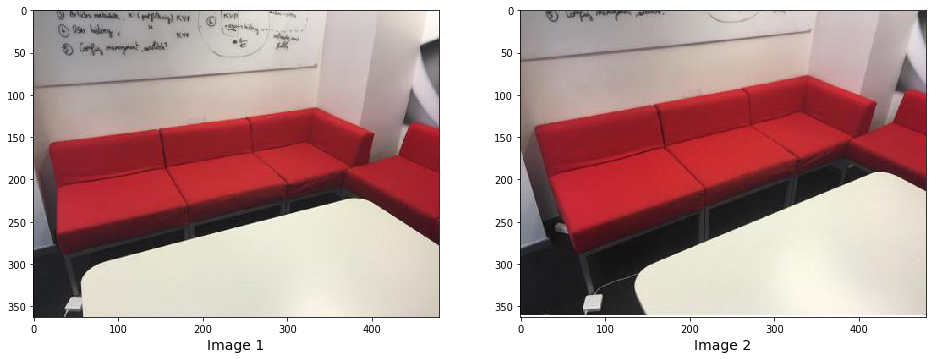

In [30]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(16,9))
pil_im1 = Image.open(file_list[0], 'r')
ax1.imshow(np.asarray(pil_im1))
ax1.set_xlabel("Image 1", fontsize=14)

pil_im2 = Image.open(file_list[1], 'r')
ax2.imshow(np.asarray(pil_im2))
ax2.set_xlabel("Image 2", fontsize=14)

plt.show()

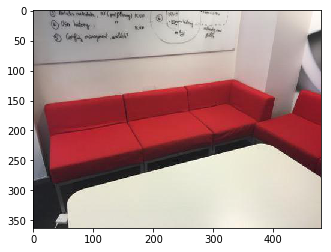

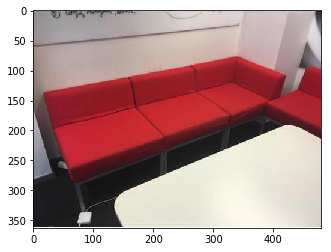

In [31]:
for p in file_list:
    plt.figure()
    pil_im = Image.open(p, 'r')
    plt.imshow(np.asarray(pil_im))

In [32]:
# Basic metrics

In [33]:
#https://www.pyimagesearch.com/2014/09/15/python-compare-two-images/

def is_exact(x, y):
    return (x == y).all()

def mse(imageA, imageB):
    # sum of the squared difference between the two images of same dimension
    # the lower the error, the more "similar" the two images are
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err = err/float(imageA.shape[0] * imageA.shape[1])
    return err
 
def compare_images(imageA, imageB):
    exact = is_exact(imageA, imageB)
    # compute the mean squared error
    m = mse(imageA, imageB)
    # compute the structural similarity
    s = ssim(imageA, imageB,multichannel=True)
    return exact,m,s

In [34]:
exact,m,s = compare_images(img1, img2)
print("Exact : %s, MSE: %.3f, SSIM: %.3f" % (exact, m, s))

Exact : False, MSE: 12060.880, SSIM: 0.594


In [35]:
if exact:
    print("Images are the same")
#use threshold
elif s > 0.6:
    print("Images are similar and considered as same")
else:
    print("Images are different")

Images are different


In [ ]:
# # Compute feature extraction from both images with ORB method
# # input two matrices and a feature detector method
# # return a descriptor for both images with same size
# def extract_features(matA, matB, method):
#     try:
#         if method == "ORB":
#             alg1 = cv2.ORB_create()
#             alg2 = cv2.ORB_create()
#         # detecting image keypoints
#         kps1 = alg1.detect(matA)
#         kps2 = alg2.detect(matB)
#         # computing number of key points
#         vector_size = min(len(kps1),len(kps2))
#         kps1 = sorted(kps1, key=lambda x: -x.response)[:vector_size]
#         kps2 = sorted(kps2, key=lambda x: -x.response)[:vector_size]
#         # computing descriptors vector
#         kps1, desc1 = alg1.compute(matA, kps1)
#         kps2, desc2 = alg2.compute(matB, kps2)
#         desc1 = desc1.flatten()
#         desc2 = desc2.flatten()
#         # Making descriptor of same size
#         # Descriptor vector size is 64
#         needed_size = (vector_size * 64)
#         if desc1.size < needed_size:
#             desc1 = np.concatenate([desc1, np.zeros(needed_size - desc1.size)])
#         if desc2.size < needed_size:
#             desc2 = np.concatenate([desc2, np.zeros(needed_size - desc2.size)])
#         return desc1,desc2
#     except Exception as e:
#         print('Error in extract features : {}'.format(e))
#         exit()

# # Compute cosine distance between two vectors
# # input two vectors
# # return cosine distance between the vectors
# def cos_dist(vector1,vector2):
#     v1 = vector1.reshape(1, -1)
#     v2 = vector2.reshape(1, -1)
#     return scipy.spatial.distance.cdist(v1, v2, 'cosine')

# # Compute cosine distance between key points matrices
# # intput two matrices
# # return a key point distance. output = 0 for similar data ; output = 1 for very different data
# def cosdist_kp(matA,matB):
#     method = "ORB"
#     features1,features2 = extract_features(matA,matB,method)
#     if features1 and features2:
#         img_distances = cos_dist(features1,features2)
#         score_kp = img_distances[0][0]
#         return score_kp
#     else:
#         return None

            # method = "ORB"
            # features1,features2 = extract_features(img1,img2,method)
            # img_distances = cosdist_kp(features1,features2)
            # #output = 0 for similar data ; output = 1 for very different data
            # score_kp = img_distances[0][0]
            # print("Score Keypoints : %.3f" % (score_kp))
            # #use threshold
            # if score_kp < 0.215:
            #     print("Similar images")
            #     return True
            # else:
            #     print("Different images")
            #     return False

In [36]:
#https://stackoverflow.com/questions/843972/image-comparison-fast-algorithm

In [37]:
#https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_sift_intro/py_sift_intro.html

In [179]:
# dev sift

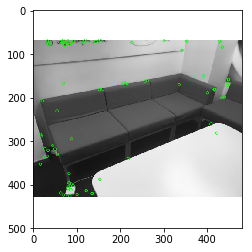

In [22]:
img = cv2.imread("./data/test1/25_758351074.jpg")
gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

sift = cv2.xfeatures2d.SIFT_create()
kp = sift.detect(gray,None)

img=cv2.drawKeypoints(gray,kp,None,color=(0,255,0))

plt.imshow(img)

In [23]:
#keypoints are founded on the entire image, could be a problem
print("Number of key points: {}".format(len(kp)))

Number of key points: 92


In [24]:
#use strereo to get matching points between images

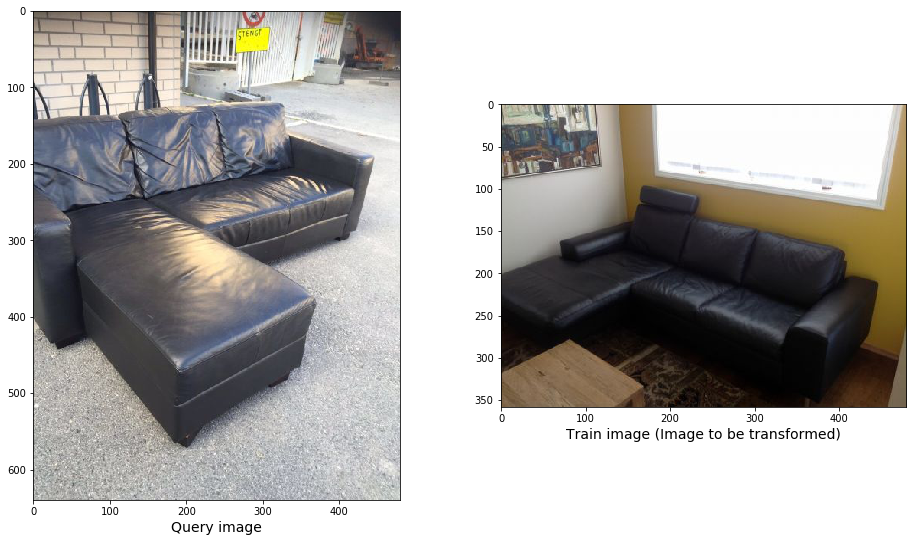

In [180]:
# read images and transform them to grayscale
# Make sure that the train image is the image that will be transformed
trainImg = imageio.imread(files[0])
trainImg_gray = cv2.cvtColor(trainImg, cv2.COLOR_RGB2GRAY)

queryImg = imageio.imread(files[1])
# Opencv defines the color channel in the order BGR. 
# Transform it to RGB to be compatible to matplotlib
queryImg_gray = cv2.cvtColor(queryImg, cv2.COLOR_RGB2GRAY)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(16,9))
ax1.imshow(queryImg, cmap="gray")
ax1.set_xlabel("Query image", fontsize=14)

ax2.imshow(trainImg, cmap="gray")
ax2.set_xlabel("Train image (Image to be transformed)", fontsize=14)

plt.show()

In [181]:
def detectAndDescribe(image, method=None):
    """
    Compute key points and feature descriptors using an specific method
    """
    
    assert method is not None, "You need to define a feature detection method. Values are: 'sift', 'surf'"
    
    # detect and extract features from the image
    if method == 'sift':
        descriptor = cv2.xfeatures2d.SIFT_create()
    elif method == 'surf':
        descriptor = cv2.xfeatures2d.SURF_create()
    elif method == 'brisk':
        descriptor = cv2.BRISK_create()
    elif method == 'orb':
        descriptor = cv2.ORB_create()
        
    # get keypoints and descriptors
    (kps, features) = descriptor.detectAndCompute(image, None)
    
    return (kps, features)

In [182]:
feature_extractor = "sift"
kpsA, featuresA = detectAndDescribe(trainImg_gray, method=feature_extractor)
kpsB, featuresB = detectAndDescribe(queryImg_gray, method=feature_extractor)

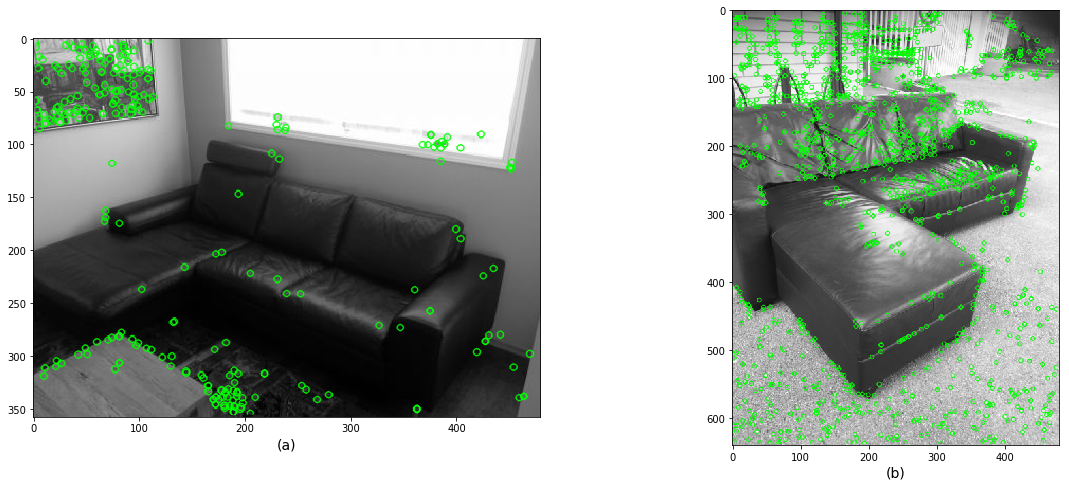

In [183]:
# display the keypoints and features detected on both images
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
ax1.imshow(cv2.drawKeypoints(trainImg_gray,kpsA,None,color=(0,255,0)))
ax1.set_xlabel("(a)", fontsize=14)
ax2.imshow(cv2.drawKeypoints(queryImg_gray,kpsB,None,color=(0,255,0)))
ax2.set_xlabel("(b)", fontsize=14)

plt.show()

In [184]:
def createMatcher(method,crossCheck):
    "Create and return a Matcher Object"
    
    if method == 'sift' or method == 'surf':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)
    elif method == 'orb' or method == 'brisk':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=crossCheck)
    return bf

def matchKeyPointsBF(featuresA, featuresB, method):
    bf = createMatcher(method, crossCheck=True)
        
    # Match descriptors.
    best_matches = bf.match(featuresA,featuresB)
    
    # Sort the features in order of distance.
    # The points with small distance (more similarity) are ordered first in the vector
    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    print("Raw matches (Brute force):", len(rawMatches))
    return rawMatches

def matchKeyPointsKNN(featuresA, featuresB, ratio, method):
    bf = createMatcher(method, crossCheck=False)
    # compute the raw matches and initialize the list of actual matches
    rawMatches = bf.knnMatch(featuresA, featuresB, 2)
    print("Raw matches (knn):", len(rawMatches))
    matches = []

    # loop over the raw matches
    for m,n in rawMatches:
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe's ratio test)
        if m.distance < n.distance * ratio:
            matches.append(m)
    return matches

Using: bf feature matcher
Raw matches (Brute force): 245


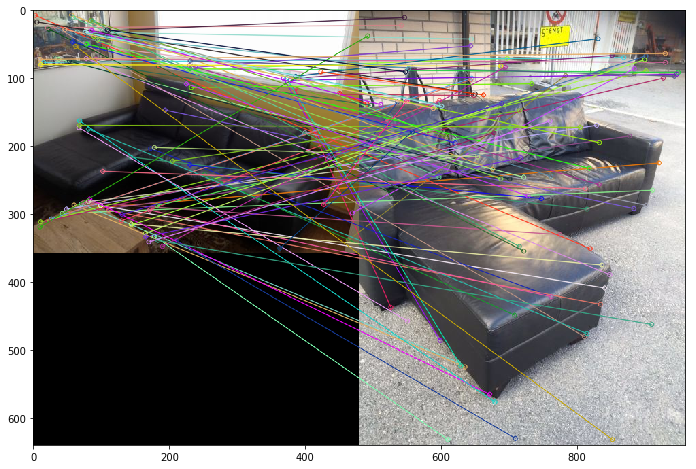

In [185]:
feature_matching = 'bf'
print("Using: {} feature matcher".format(feature_matching))

fig = plt.figure(figsize=(20,8))

if feature_matching == 'bf':
    matches = matchKeyPointsBF(featuresA, featuresB, method=feature_extractor)
    img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,matches[:100],
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
elif feature_matching == 'knn':
    matches = matchKeyPointsKNN(featuresA, featuresB, ratio=0.75, method=feature_extractor)
    img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,np.random.choice(matches,100),
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    

plt.imshow(img3)
plt.show()

[[ 1.72077805e+00 -1.31916529e+00  1.21839114e+02]
 [ 3.22329872e+00 -2.51649700e+00  1.79788663e+02]
 [ 1.56806059e-02 -1.25316545e-02  1.00000000e+00]]


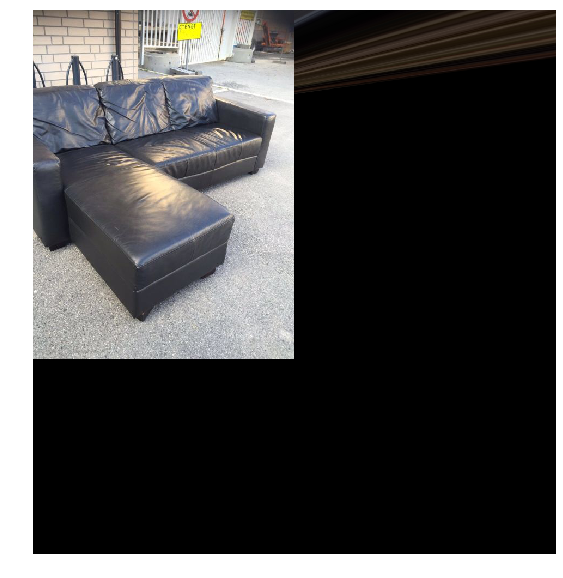

In [186]:
def getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh):
    # convert the keypoints to numpy arrays
    kpsA = np.float32([kp.pt for kp in kpsA])
    kpsB = np.float32([kp.pt for kp in kpsB])
    
    if len(matches) > 4:

        # construct the two sets of points
        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])
        
        # estimate the homography between the sets of points
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
            reprojThresh)

        return (matches, H, status)
    else:
        return None
    
M = getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh=4)
if M is None:
    print("Error!")
(matches, H, status) = M
print(H)

# Apply panorama correction
width = trainImg.shape[1] + queryImg.shape[1]
height = trainImg.shape[0] + queryImg.shape[0]

result = cv2.warpPerspective(trainImg, H, (width, height))
result[0:queryImg.shape[0], 0:queryImg.shape[1]] = queryImg

plt.figure(figsize=(20,10))
plt.imshow(result)

plt.axis('off')
plt.show()

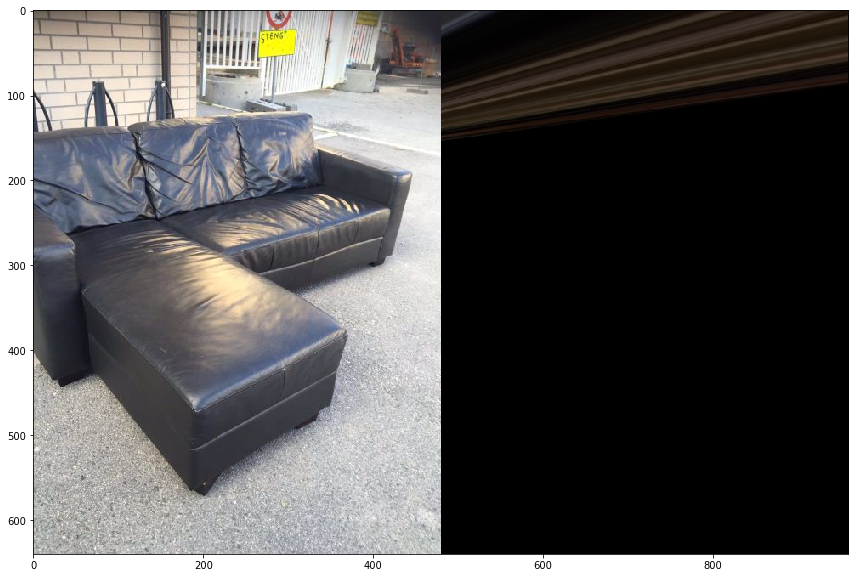

In [187]:
# transform the panorama image to grayscale and threshold it 
gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

# Finds contours from the binary image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# get the maximum contour area
c = max(cnts, key=cv2.contourArea)

# get a bbox from the contour area
(x, y, w, h) = cv2.boundingRect(c)

# crop the image to the bbox coordinates
result = result[y:y + h, x:x + w]

# show the cropped image
plt.figure(figsize=(20,10))
plt.imshow(result)

In [33]:
# Cosine distance between matrices of keypoints of both images

In [19]:
from scipy.misc import imread
import scipy

In [17]:
def extract_features(image_path1, image_path2,method):
    image1 = plt.imread(image_path1)
    image2 = plt.imread(image_path2)
    try:
        # Using KAZE, cause SIFT, ORB and other was moved to additional module
        # which is adding addtional pain during install
        #alg = cv2.KAZE_create()
        if method == "SIFT":
            alg1 = cv2.xfeatures2d.SIFT_create()
            alg2 = cv2.xfeatures2d.SIFT_create()
        if method == "ORB":
            alg1 = cv2.ORB_create()
            alg2 = cv2.ORB_create()
        # Dinding image keypoints
        kps1 = alg1.detect(image1)
        kps2 = alg2.detect(image2)
        vector_size = min(len(kps1),len(kps2))
        # Getting first 32 of them. 
        # Number of keypoints is varies depend on image size and color pallet
        # Sorting them based on keypoint response value(bigger is better)
        kps1 = sorted(kps1, key=lambda x: -x.response)[:vector_size]
        kps2 = sorted(kps2, key=lambda x: -x.response)[:vector_size]
        # computing descriptors vector
        kps1, dsc1 = alg1.compute(image1, kps1)
        kps2, dsc2 = alg2.compute(image2, kps2)
        # Flatten all of them in one big vector - our feature vector
        dsc1 = dsc1.flatten()
        dsc2 = dsc2.flatten()
        # Making descriptor of same size
        # Descriptor vector size is 64
        needed_size = (vector_size * 64)
        if dsc1.size < needed_size:
            # if we have less the 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc1 = np.concatenate([dsc1, np.zeros(needed_size - dsc1.size)])
        if dsc2.size < needed_size:
            # if we have less the 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc2 = np.concatenate([dsc2, np.zeros(needed_size - dsc2.size)])
    except cv2.error as e:
        print('Error: ', e)
        return None
    return dsc1,dsc2

def cos_cdist(vector1,vector2):
    # getting cosine distance between search image and images database
    v1 = vector1.reshape(1, -1)
    v2 = vector2.reshape(1, -1)
    return scipy.spatial.distance.cdist(v1, v2, 'cosine')

In [47]:
path1 = "./data/test5/50_787542253.jpg"
path2 ="./data/test5/93_2015287802.jpg"

method = "ORB"
features1,features2 = extract_features(path1,path2,method)
img_distances = cos_cdist(features1,features2)

In [52]:
#output = 0 for similar data ; output = 1 for very different data
score_kp = img_distances[0][0]
print(score_kp)

#dist_kp = np.linalg.norm(features1-features2)
#print(dist_kp)

0.20280523592435284


In [53]:
if score_kp < 0.215:
    print("Similar images")
else:
    print("Different images")

Similar images


In [188]:
#dev

In [41]:
MIN_MATCH_COUNT = 10

img1 = cv2.imread('./data/test_noir/05_130487674.jpg',0)          # queryImage
img2 = cv2.imread('./data/test_noir/08_349722388.jpg',0) # trainImage

# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1,des2,k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

In [42]:
src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
print(src_pts)
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
print(dst_pts)

[[[304.8251  263.08755]]

 [[461.64276 128.60622]]]
[[[142.55867 323.8487 ]]

 [[309.9048  192.31638]]]


In [45]:
print(len(dst_pts))

2


In [46]:
#cos_cdist(src_pts,dst_pts)

In [193]:
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()

    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)

    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

else:
    print("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
    matchesMask = None

Not enough matches are found - 5/10


In [ ]:
"./data/test4/66_642824605.jpg"

In [7]:
#extension = ".jpg"

In [50]:
#clean folder
files_remove = glob.glob("./data/test5/*_rotate*"+extension)
for filepath in files_remove:
    os.remove(filepath)